In [1]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
query = '''
        select f.film_id, f.release_year, f.rental_duration, f.rental_rate, f.length, f.rating, r.rental_date as total_rents
        from film f
        left join inventory i using(film_id)
        left join rental r using(inventory_id);
        '''

data = pd.read_sql_query(query, engine)
data

,film_id,release_year,rental_duration,rental_rate,length,rating,total_rents
0,1,2006,6,0.99,86,PG,2005-07-08 19:03:15
1,1,2006,6,0.99,86,PG,2005-08-02 20:13:10
2,1,2006,6,0.99,86,PG,2005-08-21 21:27:43
3,1,2006,6,0.99,86,PG,2022-11-12 16:43:45
4,1,2006,6,0.99,86,PG,2005-05-30 20:21:07
...,...,...,...,...,...,...,...
16083,1000,2006,3,4.99,50,NC-17,2005-05-29 03:49:03
16084,1000,2006,3,4.99,50,NC-17,2005-06-15 21:50:32
16085,1000,2006,3,4.99,50,NC-17,2005-07-12 13:24:47
16086,1000,2006,3,4.99,50,NC-17,2005-07-31 07:32:21


In [4]:
print(data.columns)

Index(['film_id', 'release_year', 'rental_duration', 'rental_rate', 'length',
       'rating', 'total_rents'],
      dtype='object')


In [5]:
data_1 = data.groupby(['film_id', 'release_year', 'rental_duration',
       'rental_rate', 'length', 'rating'], as_index=False).agg({'total_rents':'count'})

In [6]:
data_1

,film_id,release_year,rental_duration,rental_rate,length,rating,total_rents
0,1,2006,6,0.99,86,PG,24
1,2,2006,3,4.99,48,G,7
2,3,2006,7,2.99,50,NC-17,12
3,4,2006,5,2.99,117,G,23
4,5,2006,6,2.99,130,G,12
...,...,...,...,...,...,...,...
995,996,2006,6,0.99,183,G,7
996,997,2006,4,0.99,179,NC-17,6
997,998,2006,6,0.99,105,NC-17,9
998,999,2006,5,2.99,101,R,17


In [7]:
data_1.dtypes

film_id              int64
release_year         int64
rental_duration      int64
rental_rate        float64
length               int64
rating              object
total_rents          int64
dtype: object

In [8]:
data_1['rating'].value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [9]:
data_1['rental_duration'].value_counts()

6    212
3    203
4    203
7    191
5    191
Name: rental_duration, dtype: int64

In [10]:
#data_1['rental_duration'] = data_1['rental_duration'].astype('object')

In [11]:
data_1['release_year'].value_counts()

2006    1000
Name: release_year, dtype: int64

In [12]:
data_1 = data_1.drop('release_year', axis=1)

In [13]:
data_1['rental_rate'].value_counts()

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64

In [14]:
#data_1['rental_rate'] = data_1['rental_rate'].astype('object')

In [15]:
data_1.isna().sum()

film_id            0
rental_duration    0
rental_rate        0
length             0
rating             0
total_rents        0
dtype: int64

In [16]:
data_1.dtypes

film_id              int64
rental_duration      int64
rental_rate        float64
length               int64
rating              object
total_rents          int64
dtype: object

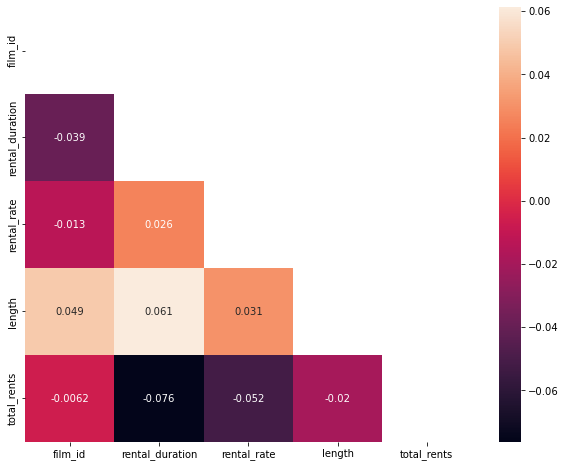

In [17]:
correlations_matrix = data_1.corr(method='spearman')
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

#### There is no great correlation among features. Film_id will be made Index in the next steps.

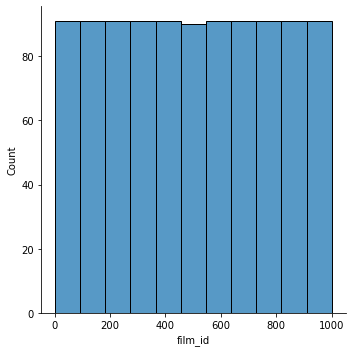

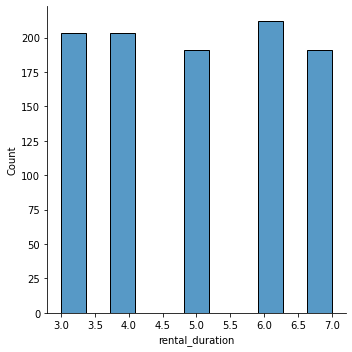

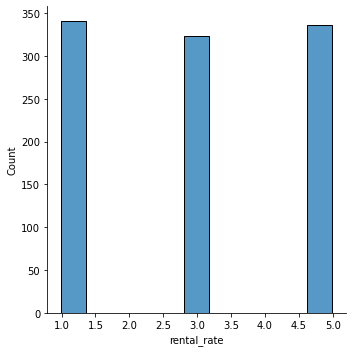

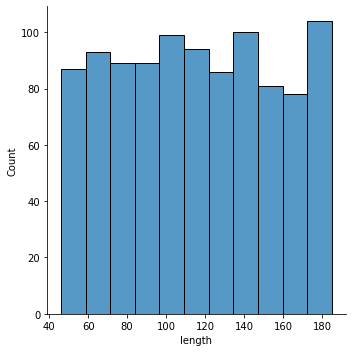

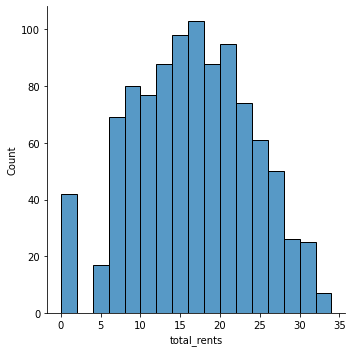

In [18]:
for col in data_1.select_dtypes(np.number):
    sns.displot(data_1[col])
    plt.show()

### Adding the bollean variable for movies rented in the last month.

In [29]:
#To get movies rented in the last month, I consider August 2005 as the last month before 
#the last month available in the database.

query_2 = '''
        select f.film_id, i.inventory_id, f.title, r.rental_date, 
        case
        when date_format(convert(r.rental_date,date), '%%Y-%%m') = '2005-08' then True
        when date_format(convert(r.rental_date,date), '%%Y-%%m') != '2005-08' then False
        end as last_month_rent
        from film f
        left join inventory i using(film_id)
        left join rental r using(inventory_id);
        '''

data_2 = pd.read_sql_query(query_2, engine)
data_2

,film_id,inventory_id,title,rental_date,last_month_rent
0,1,1.0,ACADEMY DINOSAUR,2005-07-08 19:03:15,0.0
1,1,1.0,ACADEMY DINOSAUR,2005-08-02 20:13:10,1.0
2,1,1.0,ACADEMY DINOSAUR,2005-08-21 21:27:43,1.0
3,1,1.0,ACADEMY DINOSAUR,2022-11-12 16:43:45,0.0
4,1,2.0,ACADEMY DINOSAUR,2005-05-30 20:21:07,0.0
...,...,...,...,...,...
16083,1000,4581.0,ZORRO ARK,2005-05-29 03:49:03,0.0
16084,1000,4581.0,ZORRO ARK,2005-06-15 21:50:32,0.0
16085,1000,4581.0,ZORRO ARK,2005-07-12 13:24:47,0.0
16086,1000,4581.0,ZORRO ARK,2005-07-31 07:32:21,0.0


In [30]:
data_2.groupby(['title'],as_index=False).agg({'last_month_rent':max})

,title,last_month_rent
0,ACADEMY DINOSAUR,1.0
1,ACE GOLDFINGER,1.0
2,ADAPTATION HOLES,1.0
3,AFFAIR PREJUDICE,1.0
4,AFRICAN EGG,1.0
...,...,...
995,YOUNG LANGUAGE,1.0
996,YOUTH KICK,1.0
997,ZHIVAGO CORE,1.0
998,ZOOLANDER FICTION,1.0


In [31]:
data_2 = data_2.groupby(['title'],as_index=False).agg({'last_month_rent':max}).fillna(0)

In [32]:
data_test = pd.concat([data_1,data_2],axis=1)
data_test

,film_id,rental_duration,rental_rate,length,rating,total_rents,title,last_month_rent
0,1,6,0.99,86,PG,24,ACADEMY DINOSAUR,1.0
1,2,3,4.99,48,G,7,ACE GOLDFINGER,1.0
2,3,7,2.99,50,NC-17,12,ADAPTATION HOLES,1.0
3,4,5,2.99,117,G,23,AFFAIR PREJUDICE,1.0
4,5,6,2.99,130,G,12,AFRICAN EGG,1.0
...,...,...,...,...,...,...,...,...
995,996,6,0.99,183,G,7,YOUNG LANGUAGE,1.0
996,997,4,0.99,179,NC-17,6,YOUTH KICK,1.0
997,998,6,0.99,105,NC-17,9,ZHIVAGO CORE,1.0
998,999,5,2.99,101,R,17,ZOOLANDER FICTION,1.0


In [33]:
data_test = data_test.set_index('film_id')
data_test

,rental_duration,rental_rate,length,rating,total_rents,title,last_month_rent
film_id,,,,,,,
1,6,0.99,86,PG,24,ACADEMY DINOSAUR,1.0
2,3,4.99,48,G,7,ACE GOLDFINGER,1.0
3,7,2.99,50,NC-17,12,ADAPTATION HOLES,1.0
4,5,2.99,117,G,23,AFFAIR PREJUDICE,1.0
5,6,2.99,130,G,12,AFRICAN EGG,1.0
...,...,...,...,...,...,...,...
996,6,0.99,183,G,7,YOUNG LANGUAGE,1.0
997,4,0.99,179,NC-17,6,YOUTH KICK,1.0
998,6,0.99,105,NC-17,9,ZHIVAGO CORE,1.0


In [34]:
data_test.dtypes

rental_duration      int64
rental_rate        float64
length               int64
rating              object
total_rents          int64
title               object
last_month_rent    float64
dtype: object

In [35]:
X = pd.get_dummies(data_test.drop('last_month_rent', axis=1))

y = data_test['last_month_rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00       192

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



#### The business case as proposed, returns a model that is 100% accurate. This comes from almost all movies having been rented in the last month, so the predications of the model are always accurate.

#### In this case, the movies not rented in August 2005 are the ones that are not predicted to be rented in the future, which would be the movies with 0 as teh value for last_month_rent:

In [27]:
data_test[data_test['last_month_rent'] == 0]

,rental_duration,rental_rate,length,rating,total_rents,title,last_month_rent
film_id,,,,,,,
14,6,0.99,94,NC-17,0,ALICE FANTASIA,0.0
33,5,2.99,153,PG-13,0,APOLLO TEEN,0.0
36,7,0.99,127,PG-13,0,ARGONAUTS TOWN,0.0
38,6,0.99,68,NC-17,0,ARK RIDGEMONT,0.0
41,4,0.99,137,PG,0,ARSENIC INDEPENDENCE,0.0
87,7,0.99,76,NC-17,0,BOONDOCK BALLROOM,0.0
108,6,0.99,67,PG-13,0,BUTCH PANTHER,0.0
128,7,0.99,183,G,0,CATCH AMISTAD,0.0
144,7,4.99,61,PG,0,CHINATOWN GLADIATOR,0.0
